In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [169]:
df = pd.read_csv('project_dataset/train_normalized.csv', skipinitialspace=True)

### Rimuovo le features inutili

In [170]:
df.drop(["name", "artists", "album_name", "time_signature", "mode"], axis=1, inplace=True)

In [171]:
df.head()

,explicit,key,genre,duration_ms,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,False,5,j-dance,0.053798,0.522727,0.687095,0.512990,0.684705,0.082251,0.303213,0.53600,0.274226,0.638191,0.588314
1,False,1,iranian,0.103137,0.000000,0.017048,0.195984,0.438016,0.063532,0.284137,0.93400,0.354642,0.033769,0.238030
2,False,2,black-metal,0.076181,0.034091,0.334268,0.853997,0.786902,0.018608,0.000090,0.80000,0.254886,0.491457,0.453757
3,False,5,bluegrass,0.060639,0.261364,0.506905,0.584992,0.823849,0.059128,0.066667,0.00127,0.107288,0.386935,0.581263
4,False,7,happy,0.069873,0.284091,0.636383,0.686994,0.708606,0.034244,0.000578,0.09690,0.292549,0.640201,0.597435


### Pattern mining preprocessing

In [172]:
df_class = df
continuous_features = ["duration_ms", "popularity", "danceability", "energy", "loudness", "speechiness", "acousticness", "liveness", "valence", "tempo"]

for f in continuous_features:
    df[f+"_bin"] = pd.qcut(df[f], 5, duplicates='drop', labels=["veryLow", "low", "medium", "high", "veryHigh"])
    df[f+"_bin"] = df[f+"_bin"].astype(str) + "_"+f[0:3]

df.drop(continuous_features, axis=1, inplace=True)

df["instrumentalness_bin"] = pd.qcut(df["instrumentalness"], 5, duplicates='drop', labels=["veryLow", "low", "medium", "high"])
df["instrumentalness_bin"] = df["instrumentalness_bin"].astype(str) + "_ins"

df.drop(["instrumentalness"], axis=1, inplace=True)

cat_features = ["key"]
for f in cat_features:
    df[f] = df[f].astype(int).astype(str) + "_"+f
    

#exp_dict = {True: "explicit", False: "not_explicit"}
#df["explicit"] = df["explicit"].map(exp_dict)
df.drop(["explicit"], axis=1, inplace=True)

X = df.values.tolist()

In [173]:
df.head()

,key,genre,duration_ms_bin,popularity_bin,danceability_bin,energy_bin,loudness_bin,speechiness_bin,acousticness_bin,liveness_bin,valence_bin,tempo_bin,instrumentalness_bin
0,5_key,j-dance,medium_dur,high_pop,high_dan,low_ene,veryLow_lou,high_spe,high_aco,high_liv,high_val,high_tem,medium_ins
1,1_key,iranian,veryHigh_dur,veryLow_pop,veryLow_dan,veryLow_ene,veryLow_lou,high_spe,medium_aco,veryHigh_liv,veryLow_val,veryLow_tem,high_ins
2,2_key,black-metal,veryHigh_dur,veryLow_pop,veryLow_dan,high_ene,medium_lou,low_spe,veryLow_aco,high_liv,medium_val,low_tem,medium_ins
3,5_key,bluegrass,high_dur,medium_pop,low_dan,low_ene,high_lou,high_spe,low_aco,medium_liv,medium_val,high_tem,low_ins
4,7_key,happy,high_dur,medium_pop,high_dan,medium_ene,low_lou,medium_spe,veryLow_aco,high_liv,high_val,high_tem,medium_ins


## Pattern Mining

In [174]:
from fim import fpgrowth

### Pattern extraction

In [175]:
supp = 10#%
zmin = 2  # minimum number of items per item set

itemsets = fpgrowth(X, target="s", supp=supp, zmin=zmin, report="S")
a = pd.DataFrame(itemsets, columns=["frequent_itemset", "support"])
a.sort_values(by="support", axis=0, ascending=False)

,frequent_itemset,support
5,"(veryLow_lou, veryLow_ene)",13.898583
11,"(veryHigh_aco, veryLow_ene)",13.754876
4,"(high_aco, veryLow_ins)",11.996168
13,"(veryHigh_aco, veryLow_lou)",11.749812
17,"(veryHigh_pop, veryLow_ins)",11.428180
2,"(veryLow_val, veryLow_dan)",11.407651
8,"(medium_aco, veryLow_ins)",11.086019
3,"(veryHigh_lou, veryLow_ins)",11.065490
1,"(veryLow_spe, veryLow_ins)",10.757545
9,"(low_dur, veryLow_ins)",10.620680


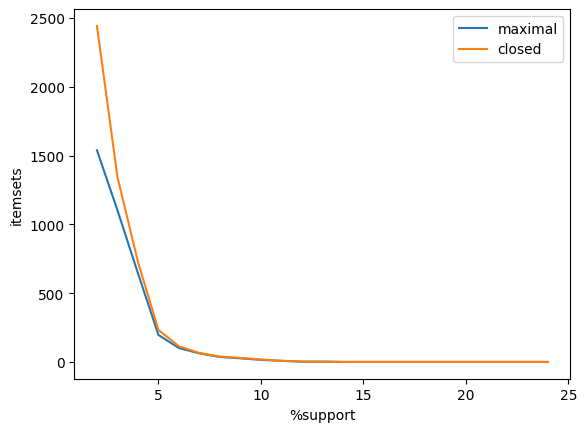

In [176]:
len_max_it = []
len_cl_it = []
max_supp = 25
for i in range(2, max_supp):
    max_itemsets = fpgrowth(X, target="m", supp=i, zmin=zmin)
    cl_itemsets = fpgrowth(X, target="c", supp=i, zmin=zmin)
    len_max_it.append(len(max_itemsets))
    len_cl_it.append(len(cl_itemsets))

plt.plot(np.arange(2, max_supp), len_max_it, label="maximal")
plt.plot(np.arange(2, max_supp), len_cl_it, label="closed")
plt.legend()
plt.xlabel("%support")
plt.ylabel("itemsets")

plt.show()
#il grafico non indica qual è il miglior support da scegliere, serve a confermare idee che già abbiamo. Può essere utile 

### Rule extraction

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


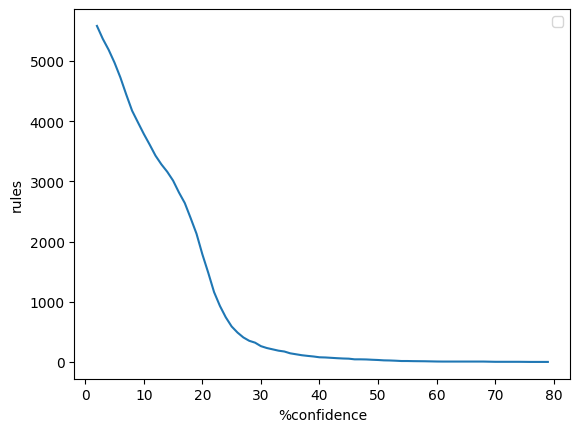

In [177]:
lens = []
for conf in range(2, 80):
    rules = fpgrowth(X, target="r", supp=supp, zmin=zmin, conf=conf, report="aScl")
    lens.append(len(rules))

plt.plot(np.arange(2, 80), lens)
plt.legend()
plt.xlabel("%confidence")
plt.ylabel("rules")
plt.show()

In [178]:
conf = 59
rules = fpgrowth(X, target="r", supp=supp, zmin=zmin, conf=conf, report="ascl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)
rules_df.sort_values(by="lift", axis=0, ascending=False).head(20)
#ci interessano solo le rules con lift maggiore di 1

,consequent,antecedent,abs_support,%_support,confidence,lift
6,veryLow_ene,"(veryHigh_aco, veryLow_lou)",1523,0.104222,0.887012,4.423860
7,veryLow_lou,"(veryHigh_aco, veryLow_ene)",1523,0.104222,0.757711,3.788039
8,veryHigh_aco,"(veryLow_lou, veryLow_ene)",1523,0.104222,0.749877,3.751438
1,veryLow_ene,"(veryLow_lou,)",2031,0.138986,0.694834,3.465396
2,veryLow_lou,"(veryLow_ene,)",2031,0.138986,0.693174,3.465396
4,veryLow_ene,"(veryHigh_aco,)",2010,0.137549,0.688121,3.431913
5,veryHigh_aco,"(veryLow_ene,)",2010,0.137549,0.686007,3.431913
3,veryLow_lou,"(veryLow_val, veryLow_dan)",991,0.067816,0.594481,2.971999
9,veryLow_ins,"(veryHigh_pop,)",1670,0.114282,0.604197,1.510544
0,veryLow_ins,"(high_aco,)",1753,0.119962,0.599726,1.499367


<Axes: xlabel='confidence', ylabel='lift'>

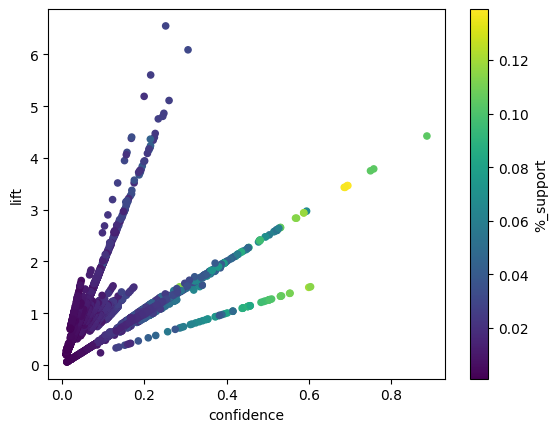

In [179]:
conf = 1
rules = fpgrowth(X, target="r", supp=supp, zmin=zmin, conf=conf, report="ascl")
rules_df = pd.DataFrame(
    rules,
    columns=[
        "consequent",
        "antecedent",
        "abs_support",
        "%_support",
        "confidence",
        "lift",
    ],
)

rules_df.plot.scatter(x="confidence", y="lift", c="%_support")

## Classificazione basata su regole

In [180]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.tree import DecisionTreeClassifier, plot_tree

In [181]:
df.head()

,key,genre,duration_ms_bin,popularity_bin,danceability_bin,energy_bin,loudness_bin,speechiness_bin,acousticness_bin,liveness_bin,valence_bin,tempo_bin,instrumentalness_bin
0,5_key,j-dance,medium_dur,high_pop,high_dan,low_ene,veryLow_lou,high_spe,high_aco,high_liv,high_val,high_tem,medium_ins
1,1_key,iranian,veryHigh_dur,veryLow_pop,veryLow_dan,veryLow_ene,veryLow_lou,high_spe,medium_aco,veryHigh_liv,veryLow_val,veryLow_tem,high_ins
2,2_key,black-metal,veryHigh_dur,veryLow_pop,veryLow_dan,high_ene,medium_lou,low_spe,veryLow_aco,high_liv,medium_val,low_tem,medium_ins
3,5_key,bluegrass,high_dur,medium_pop,low_dan,low_ene,high_lou,high_spe,low_aco,medium_liv,medium_val,high_tem,low_ins
4,7_key,happy,high_dur,medium_pop,high_dan,medium_ene,low_lou,medium_spe,veryLow_aco,high_liv,high_val,high_tem,medium_ins


In [182]:
columns = list(df.columns)
columns.remove("key")
columns.remove("genre")

#voglio togliere dai valori delle tabelle il nome della feature associata
for col in df[columns].columns:
    df[col] = df[col].replace("_"+col[0:3], "", regex=True)
df.head()

,key,genre,duration_ms_bin,popularity_bin,danceability_bin,energy_bin,loudness_bin,speechiness_bin,acousticness_bin,liveness_bin,valence_bin,tempo_bin,instrumentalness_bin
0,5_key,j-dance,medium,high,high,low,veryLow,high,high,high,high,high,medium
1,1_key,iranian,veryHigh,veryLow,veryLow,veryLow,veryLow,high,medium,veryHigh,veryLow,veryLow,high
2,2_key,black-metal,veryHigh,veryLow,veryLow,high,medium,low,veryLow,high,medium,low,medium
3,5_key,bluegrass,high,medium,low,low,high,high,low,medium,medium,high,low
4,7_key,happy,high,medium,high,medium,low,medium,veryLow,high,high,high,medium


In [183]:
diz = {"veryLow":0, "low":1, "medium":2,"high":3, "veryHigh":4}

def assignData(X_cols, y_col):
    X = df[X_cols]

    for col in X.columns:
        X[col] = X[col].map(diz)

    y = df[y_col]

    return X.values.tolist(), y.values.tolist()



In [184]:
#LE TRE RULES
X, y = assignData(["acousticness_bin", "loudness_bin"], ["energy_bin"])
#X, y = assignData(["valence_bin", "danceability_bin"], ["loudness_bin"])
#X, y = assignData(["popularity_bin"], ["instrumentalness_bin"])

#RULES A CASO
#X, y = assignData(["tempo_bin"], ["instrumentalness_bin"])

y = [x for xs in y for x in xs] #trasforma da lista di liste in lista semplice

clf = CategoricalNB()

scores = cross_val_score(clf, X, y, cv=10)
y_pred = cross_val_predict(clf, X, y, cv=10)


print(scores.mean())
print(classification_report(y, y_pred))

C:\Users\fabio\AppData\Local\Temp\ipykernel_6676\1483979322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].map(diz)
C:\Users\fabio\AppData\Local\Temp\ipykernel_6676\1483979322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].map(diz)


0.5047567816582724
              precision    recall  f1-score   support

        high       0.37      0.31      0.34      2921
         low       0.45      0.44      0.45      2920
      medium       0.36      0.28      0.31      2920
    veryHigh       0.53      0.70      0.60      2922
     veryLow       0.72      0.80      0.76      2930

    accuracy                           0.50     14613
   macro avg       0.49      0.50      0.49     14613
weighted avg       0.49      0.50      0.49     14613

